# Noise reduction 
 
The algorithm in noisereduce is based on (but not completely reproducing) on the one outlined by Audacity for the noise reduction effect (Link to C++ code).
The algorithm noisereduce required two input file: the noise signal and the signal audio clip. However, in the reality, we do not often have the noise signal, thus below will used a technique called sound envelope to create our own noise signal clip. 

#### Create noise file:
* In Audacity, it is required for us to select the noise part (when human voice are not appeared) manually. In this section, a sound envelope is used here.  

#### noisereduce algorithm 

1. An Short-time Fourier Transforamtion is calculated over the noise audio clip
2. Statistics are calculated over FFT of the the noise (in frequency: mean, standard deviation, noise threshold)
3. A threshold is calculated based upon the statistics of the noise (and the desired sensitivity of the algorithm). How many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal.
4. An STFT is calculated over the signal
5. A mask is determined by comparing the signal FFT to the threshold
6. The mask is smoothed with a filter over frequency and time
7. Calculate the threshold for each frequency/time bin, if the signal is above threshold --> convolve the mask with a smoothing filter with scipy.signal.fftconvolve
8. The mask is applied to the FFT of the signal, and is inverted with Inverse short time Fourier Transform (ISTFT) 

Full script: https://timsainburg.com/noise-reduction-python.html

In [1]:
# import neccessary libraries
import os, io
import shutil
import  joblib
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
import IPython.display

import noisereduce as nr
from matplotlib import pyplot as plt
from scipy.ndimage import maximum_filter1d
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
%matplotlib inline

/Users/michliu/opt/anaconda3/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


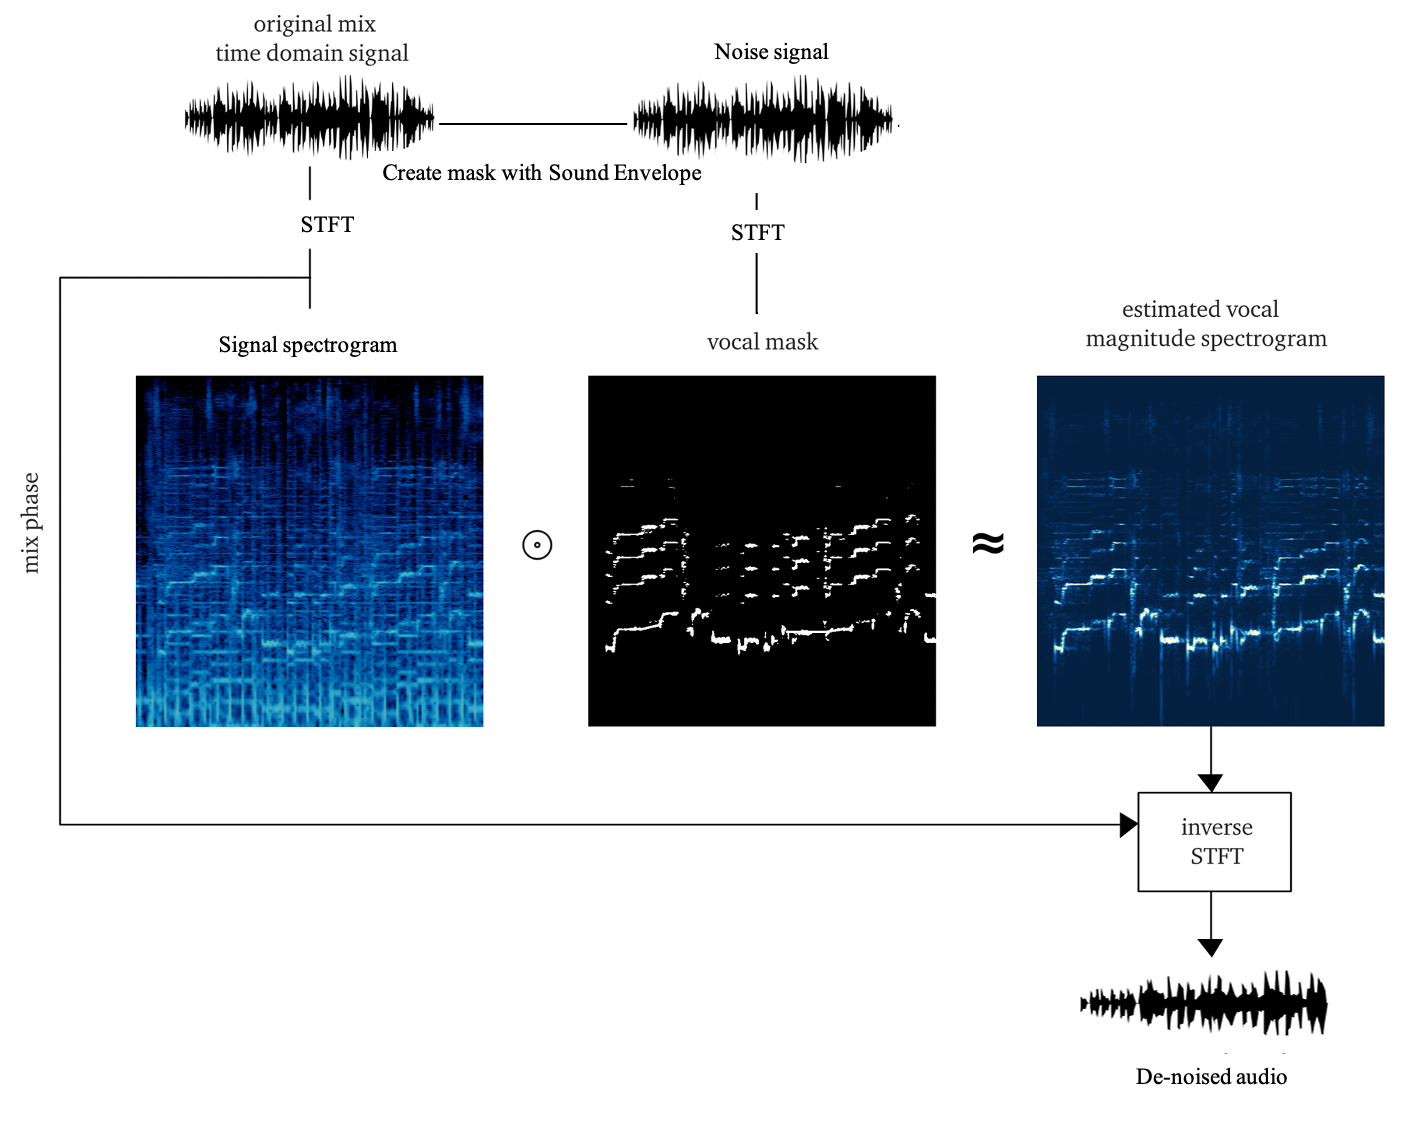

In [2]:
IPython.display.Image("/Users/michliu/Documents/HSBC - Data scientist/image/noise_reduce.png")

## Project Set-up

In [209]:
# create directories

#os.makedirs("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/transcription/")
#os.makedirs("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train/")
#os.makedirs("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder/")
#os.makedirs("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder_slower/")

In [3]:
# Path for files
AUDIO_ROOT = Path("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/transcript")
CLEAN_AUDIO_ROOT = Path("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/clean_train/")
NOISE_AUDIO_ROOT = Path("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Noise_training/")
NOISY_AUDIO_ROOT = Path("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/NoisySpeech_training/")
PROCESSED_AUDIO_ROOT = Path("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train/")
PROCESSED_AUDIO_LOUD_ROOT = Path("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder/")
PROCESSED_AUDIO_LOUD_SLOW_ROOT = Path("/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder_slower/")
TRANSCRIPT_PATH = "/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/transcription/"

In [4]:
# Set up a params class 
class params:
    """
    Parameters used for the audio data
    """
    sr = 44100 # sample rate
    thr = 0.25 # hyperparameter: threshold - how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
    prop_dec = 0.5 # Hyperparameter: prop-decrease - To what extent should you decrease noise (1 = all, 0 = none)

# Function to read and load audio file
def load_audio(record, sr, root=""):
    y, _ = lb.load(
        root.joinpath(record).with_suffix(".wav").as_posix(),
        sr=sr, 
    )
    return y

# Function to read audio
def audioread(path, norm = True, start=0, stop=None):
    path = os.path.abspath(path)
    if not os.path.exists(path):
        raise ValueError("[{}] does not exist!".format(path))
    try:
        x, sr = sf.read(path, start=start, stop=stop)
    except RuntimeError:  # fix for sph pcm-embedded shortened v2
        print('WARNING: Audio type not supported')

    if len(x.shape) == 1:  # mono
        if norm:
            rms = (x ** 2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    else:  # multi-channel
        x = x.T
        x = x.sum(axis=0)/x.shape[0]
        if norm:
            rms = (x ** 2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    
    
# Funtion to write audio    
def audiowrite(data, fs, destpath, norm=False):
    if norm:
        rms = (data ** 2).mean() ** 0.5
        scalar = 10 ** (-25 / 10) / (rms+eps)
        data = data * scalar
        if max(abs(data))>=1:
            data = data/max(abs(data), eps)
    
    destpath = os.path.abspath(destpath)
    destdir = os.path.dirname(destpath)
    
    if not os.path.exists(destdir):
        os.makedirs(destdir)
    
    sf.write(destpath, data, fs)
    return
    

## What is Sound Envelope?

The envelope of a sound displays how the level of a sound wave changes over time. If the level of sound is too low we will remove that part. 

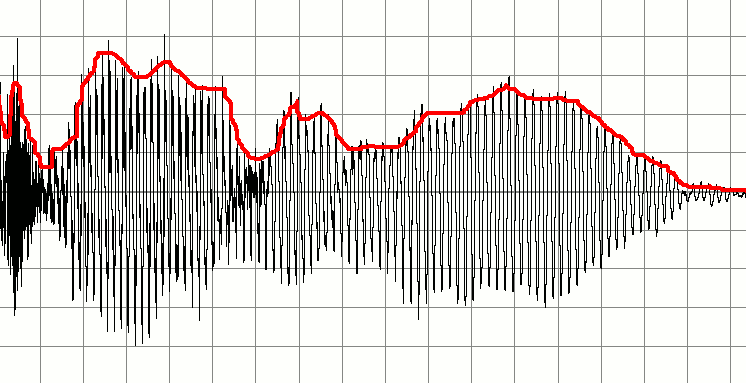

In [212]:
IPython.display.Image("/Users/michliu/Documents/HSBC - Data scientist/image/sound_envelope.png")

#### Sound Envelope (Red Line)

But how we will see if that sound level is low?
- For that we will form a threshold and everything below that threshold will be considered as unwanted noise.
- A rolling window will be passed through the audio waveform and mean will be taken.
- If that mean is less then threshold value then remove that unwanted audio

Source: https://www.kaggle.com/jainarindam/imp-remove-background-dead-noise

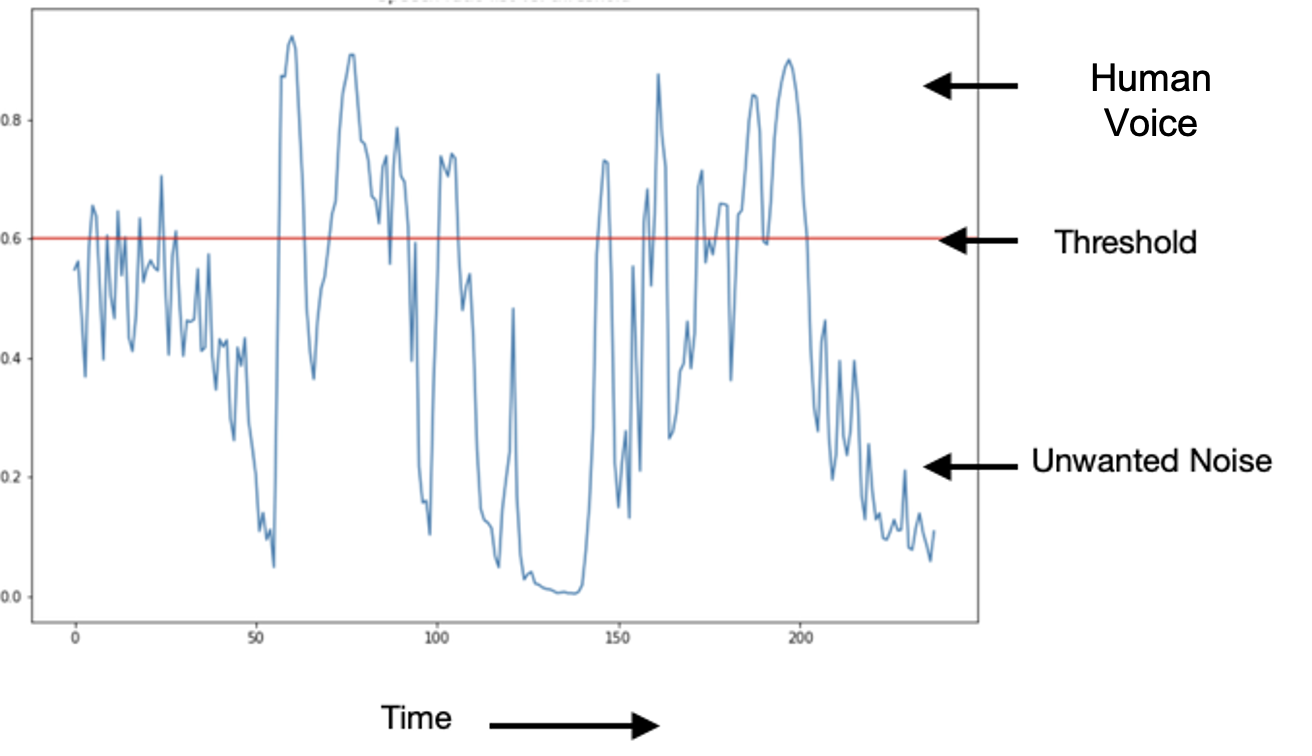

In [213]:
IPython.display.Image("/Users/michliu/Documents/HSBC - Data scientist/image/sound_envelope3.png")
# For example

In [5]:
# Create Sound Envelope
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),min_periods=1,center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

# Window size and threshold are hyperparameters.
# The higher the threshold, might remove human voice as well, so there is a trade-off to make it optimal.

## Evaluation: Google Cloud Speech-to-text API

Google Cloud Speech-to-text API are the only few API resources that are available for long audio (i.e. more than 10 minutes), which is common audio length in the call center. For audio length longer than 1 minute, it is required to upload the data to Google cloud (Asynchronous Request). In the following, we will use Asynchronous Request for audio less than 1 minute to quickly check the performance of the Noise Reduction Algorithm.

Output of the API:
* Transcript: Is the output of the text that the model returns (what the machine understood from the audio file).
* Confidence: Is a value between 0-1 that the api returns for each transcription that (assumptively) equals the confidentiality/accuracy of the model in the prediction it made (how sure the machine is that it understood correctly).


In [6]:
# To use Google Cloud API, we need to first connect to my google application credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'/Users/michliu/Downloads/practical-mason-310116-d58cfab8b943.json'


In [7]:
# Cantonese Speech-to-text API: data from local directory 
def transcribe_gcs(path, speech_file, sample_rate = 44100):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""
    from google.cloud import speech

    client = speech.SpeechClient()
    
    path = os.path.join(path, speech_file)
    with io.open(path, "rb") as audio_file:
        content = audio_file.read()

    audio = speech.RecognitionAudio(content=content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=sample_rate,
        audio_channel_count=1,
        max_alternatives = 1,
        speech_contexts": [{
      "phrases": ["weather"]
        language_code='yue-Hant-HK')
    
    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=1500)

    # Each result is for a consecutive portion of the audio. Iterate through
    # them to get the transcripts for the entire audio file.
    for result in response.results:
        # The first alternative is the most likely one for this portion.
        print(u"Transcript: {}".format(result.alternatives[0].transcript))
        print("Confidence: {}".format(result.alternatives[0].confidence))
        #print("Channel Tag: ", result.channel_tag)
        
    results = response.results
    # Write transcript in folder
    raw_text_file = open( (str(TRANSCRIPT_PATH + speech_file.split(".")[0]))  + '.txt', 'w')
    for result in results:
        for alternative in result.alternatives:
            raw_text_file.write(alternative.transcript + '\n')
    raw_text_file.close() #output raw text file of transcription

        
    return 


In [8]:
# Cantonese Speech-to-text API: data from google cloud
def transcribe_gcs_google_cloud(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""
    from google.cloud import speech

    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.FLAC,
        sample_rate_hertz=44100,
        audio_channel_count=1,
        max_alternatives = 1,
        language_code='yue-Hant-HK')
    

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=300)

    # Each result is for a consecutive portion of the audio. Iterate through
    # them to get the transcripts for the entire audio file.
    for result in response.results:
        # The first alternative is the most likely one for this portion.
        print(u"Transcript: {}".format(result.alternatives[0].transcript))
        print("Confidence: {}".format(result.alternatives[0].confidence))
        print("Channel Tag: ", result.channel_tag)
        
    results = response.results

    raw_text_file = open( r"/Users/michliu/Documents/job application/headhunt/HSBC - Data scientist/transcribe/audio1"  + '.txt', 'w')
    for result in results:
        for alternative in result.alternatives:
            raw_text_file.write(alternative.transcript + '\n')
    raw_text_file.close() #output raw text file of transcription
        
    return 

## Read audio files

In [9]:
# read noisy audio files
df_audio = pd.DataFrame({
    "recording_id": [path.stem for path in Path(NOISY_AUDIO_ROOT).glob("*.wav")],
})
df_audio.head()

,recording_id
0,noisy_Cantonese4_SNRdb_30_Restaurant_1
1,noisy_Cantonese3_SNRdb_10_Bus_1
2,noisy_Cantonese3_SNRdb_0_Park_1
3,noisy_Cantonese7_SNRdb_0_Typing_5
4,noisy_Cantonese2_SNRdb_30_Park_1


In [10]:
# read clean audio files
clean_audio = pd.DataFrame({
    "recording_id": [path.stem for path in Path(CLEAN_AUDIO_ROOT).glob("*.wav")],
})
clean_audio.head()

,recording_id
0,Cantonese1
1,Cantonese3
2,Cantonese2
3,Cantonese6
4,Cantonese7


In [11]:
# read noise audio files
noise_audio = pd.DataFrame({
    "recording_id": [path.stem for path in Path(NOISE_AUDIO_ROOT).glob("*.wav")],
})
noise_audio.head()

,recording_id
0,noisy_Cantonese4_SNRdb_30_Restaurant_1
1,noisy_Cantonese3_SNRdb_10_Bus_1
2,noisy_Cantonese3_SNRdb_0_Park_1
3,noisy_Cantonese7_SNRdb_0_Typing_5
4,noisy_Cantonese2_SNRdb_30_Park_1


## Output: De-noise all audios

In [227]:
processedspeech_dir = "/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train/"
louder_processedspeech_dir = "/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder/"

In [228]:
total_samples = len(df_audio)
print('total_samples', total_samples)
thr = 0.25
#num_samples = 0
    
for i in range(0,total_samples):
    y = load_audio(df_audio["recording_id"][i], params.sr, NOISY_AUDIO_ROOT)
    
    mask, env = envelope(y, params.sr, thr)
    y_denoise = nr.reduce_noise(audio_clip=y, noise_clip=y[np.logical_not(mask)], verbose=False)
    filename = 'pr_'+df_audio["recording_id"][i]+'.wav'

    path = os.path.join(processedspeech_dir, filename)
    audiowrite(y_denoise, params.sr, path, norm=False)


total_samples 290


In [229]:
cwd = os.getcwd()
cwd

'/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2'

### Output: a. Increase output audio volume

Due to the worse performance from the Speech-to-text API for the de-noised audio, I would like to explore if there are any ways to improve the transcription. 

When we listen to both the noisy audio and de-noised audio, it is obvious that the de-noised audio has a much lower volume. So in the below function, the volume of the de-noised audio are increased to test the performance

In [230]:
os. chdir('/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder/') 

In [231]:
# function to increase audio volume
from pydub import AudioSegment
def increase_audio_volume(filename):
    # Import audio file 
    wav_file = AudioSegment.from_file(filename) 
    # Increase by 10 decibels 
    louder_wav_file = wav_file + 10
    # Export louder audio file 
    
    filename_ = filename.split("/")[-1].split('.')[0]
   # print(filename_)

    louder_wav_file.export(out_f =  str(filename_) + "_10" + ".wav", 
                       format = "wav")

In [232]:
# read processed audio files
processed_audio = pd.DataFrame({
    "recording_id": [path.stem for path in Path(PROCESSED_AUDIO_ROOT).glob("*.wav")],
})
processed_audio.head()

,recording_id
0,pr_noisy_Cantonese3_SNRdb_40_AirportAnnounceme...
1,pr_noisy_Cantonese5_SNRdb_30_CopyMachine_2
2,pr_noisy_Cantonese2_SNRdb_30_WasherDryer_1
3,pr_noisy_Cantonese4_SNRdb_0_Babble_1
4,pr_noisy_Cantonese2_SNRdb_20_SqueakyChair_1


In [233]:
# Run increase_audio_volume function to increase volume of processed audio file 
for i in range(0, len(processed_audio)): 
    file_name = "/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train/" + processed_audio["recording_id"][i] +".wav"
    increase_audio_volume(file_name)

### Output: b. Slowdown output audio

We can see a slight improve in the perofrmance by increasing the volume for the de-noised audio. To further improve the performace, I 

In [235]:
# function to slowdown the audio
import wave
import scipy.signal as sps
def slow_down_audio(filename):
    channels = 1
    swidth = 2
    multiplier = 0.90 # slow by 10%

    spf = wave.open(filename, 'rb')
    fr=spf.getframerate() # frame rate
    signal = spf.readframes(-1)
    
    filename_ = filename.split("/")[-1].split('.')[0]

    wf = wave.open(str(filename_) + "_s" + ".wav", 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(swidth)
    wf.setframerate(fr*multiplier)
    wf.writeframes(signal)
    wf.close()


In [236]:
# read processed loud audio files
processed_audio_loud = pd.DataFrame({
    "recording_id": [path.stem for path in Path(PROCESSED_AUDIO_LOUD_ROOT).glob("*.wav")],
})
processed_audio_loud.head()

,recording_id
0,pr_noisy_Cantonese7_SNRdb_10_Hallway_1_10
1,pr_noisy_Cantonese2_SNRdb_20_SqueakyChair_1_10
2,pr_noisy_Cantonese4_SNRdb_0_Babble_1_10
3,pr_noisy_Cantonese5_SNRdb_30_Hallway_1_10
4,pr_noisy_Cantonese3_SNRdb_40_Bus_1_10


In [234]:
os. chdir('/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder_slower/') 

In [237]:
# Run increase_audio_volume function to increase volume of processed audio file 
for i in range(0, len(processed_audio_loud)): 
    file_name = "/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/Processed_train_louder/" + processed_audio_loud["recording_id"][i] +".wav"
    #print(file_name)
    slow_down_audio(file_name)

In [238]:
os. chdir('/Users/michliu/Documents/HSBC - Data scientist/audio/cantonese2/') 